# Google Stock price time series audio-visual representation

In [1]:
pip install moviepy yfinance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from moviepy.editor import AudioFileClip, VideoFileClip
import yfinance as yf # Library for fetching stock data
import pandas as pd

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



##  Data Acquisition (Google Stock Closing Price for last 3 years)

In [3]:

ticker = yf.Ticker("GOOGL")
data = ticker.history(period="3y")

time_series = data['Close'].values
dates = data.index

# Normalizing the data to a 0-1 range for consistent frequency mapping
min_val = np.min(time_series)
max_val = np.max(time_series)
time_series_normalized = (time_series - min_val) / (max_val - min_val)


In [4]:
# Time series and animation parameters
N_STEPS = len(time_series)
FPS = 30                   # Frames per second for the video
DURATION = N_STEPS / FPS

# Audio parameters
SAMPLE_RATE = 44100 # audio sample rate
MIN_FREQ = 220.0    # Freq for the lowest price (A3 note)
MAX_FREQ = 880.0    # Freq for the highest price (A5 note)

## Animation Generation


Video saving complete.


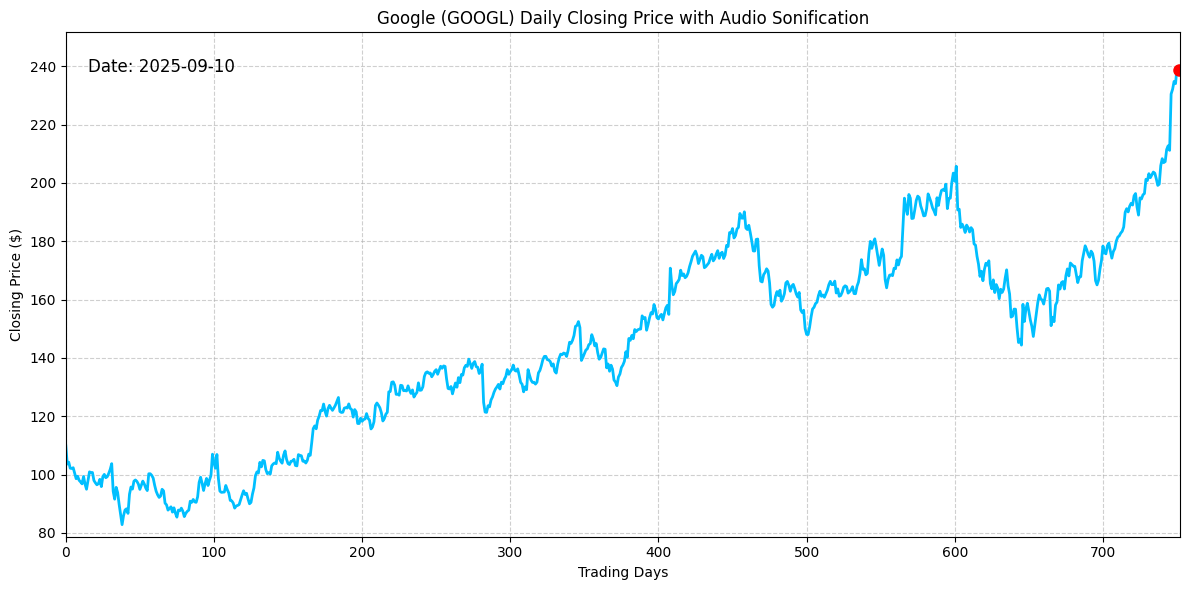

In [6]:

fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot([], [], lw=2, color='deepskyblue')
point, = ax.plot([], [], 'o', color='red', markersize=8)
date_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, ha="left", va="top", fontsize=12)

def setup_plot():
    ax.set_xlim(0, N_STEPS)
    ax.set_ylim(np.min(time_series) * 0.95, np.max(time_series) * 1.05)
    ax.set_title("Google (GOOGL) Daily Closing Price with Audio Sonification")
    ax.set_xlabel("Trading Days")
    ax.set_ylabel("Closing Price ($)")
    ax.grid(True, linestyle='--', alpha=0.6)
    fig.tight_layout()

def update(frame):
    # Update each frame of the animation
    current_idx = frame + 1

    # Update line data
    line.set_data(range(current_idx), time_series[:current_idx])

    # Update red dot's position.
    point.set_data([current_idx - 1], [time_series[current_idx - 1]])

    # Update date
    current_date = dates[frame].strftime('%Y-%m-%d')
    date_text.set_text(f"Date: {current_date}")

    return line, point, date_text,


setup_plot()
ani = animation.FuncAnimation(fig, update, frames=N_STEPS, blit=True)
video_filename = "temp_video.mp4"
ani.save(video_filename, writer='ffmpeg', fps=FPS, progress_callback=lambda i, n: print(f"  Saving video: {i/n*100:.1f}% done", end='\r'))
print("\nVideo saving complete.")

## Audio Generation

In [7]:
def sonify_series(series, duration, sample_rate, min_freq, max_freq):
    # Generates an audio waveform from the (normalized) time series."""
    total_samples = int(duration * sample_rate)
    waveform = np.zeros(total_samples)
    audio_time = np.linspace(0, duration, total_samples, endpoint=False)

    # Upsample the normalized data to match the audio sample rate
    # This creates a smooth frequency transition over time
    freq_map = np.interp(audio_time, np.linspace(0, duration, len(series)), series)
    frequency = min_freq + (freq_map * (max_freq - min_freq))

    # Generate the sine wave from the frequency map
    phase = 2 * np.pi * np.cumsum(frequency) / sample_rate
    waveform = 0.5 * np.sin(phase)

    # Apply a gentle fade-in and fade-out
    fade_len = int(0.05 * sample_rate)
    fade_in = np.linspace(0, 1, fade_len)
    fade_out = np.linspace(1, 0, fade_len)
    waveform[:fade_len] *= fade_in
    waveform[-fade_len:] *= fade_out

    return waveform

audio_waveform = sonify_series(time_series_normalized, DURATION, SAMPLE_RATE, MIN_FREQ, MAX_FREQ)

import scipy.io.wavfile as wavfile

audio_normalized = np.int16(audio_waveform / np.max(np.abs(audio_waveform)) * 32767)
audio_filename = "temp_audio.wav"
wavfile.write(audio_filename, SAMPLE_RATE, audio_normalized)
print(f"Audio saved as {audio_filename}")

print("\nCombining video and audio files...")
video_clip = VideoFileClip(video_filename)
audio_clip = AudioFileClip(audio_filename)

final_clip = video_clip.set_audio(audio_clip)
final_filename = "google_stock_sonification.mp4"
final_clip.write_videofile(final_filename, codec='libx264', audio_codec='aac')

print(f"\n Final audio-visual file saved as '{final_filename}'")

Audio saved as temp_audio.wav

Combining video and audio files...
Moviepy - Building video google_stock_sonification.mp4.
MoviePy - Writing audio in google_stock_sonificationTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video google_stock_sonification.mp4



t: 100%|█████████▉| 750/753 [00:14<00:00, 70.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file temp_video.mp4, 2160000 bytes wanted but 0 bytes read,at frame 752/753, at time 25.07/25.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready google_stock_sonification.mp4

 Final audio-visual file saved as 'google_stock_sonification.mp4'


### Appropriateness of the Audio Feature chosen to reflect the variation in the time series.
For this sonification, the magnitude of the daily stock price was mapped to the pitch (frequency) of a sine wave. This is a highly effective and intuitive choice because the human auditory system is exceptionally sensitive to changes in frequency. This creates a direct sensory link: as the stock price rises, the pitch goes up, and as it falls, the pitch goes down. This mapping transforms the abstract financial chart into a tangible auditory experience, allowing the listener to perceive the market's "melody."

This helps us understand the data's dynamics better instantly, through our audio-visual perception.

 Periods of stability are heard as a relatively steady tone, while periods of high volatility, such as market corrections or reactions to earnings reports, become a frantic and dissonant sequence of high and low notes.

 This audio-visual representation reveals the rhythm and character of the stock's performance in ways that a purely visual chart cannot. It makes the underlying patterns in the time series more memorable and meaningful.

### Challenges in Synchronizing Audio and Visuals

Synchronizing audio and video was tricky because:

Different scales & drift: Video runs at low frame rates (30 fps) while audio is continuous and densely sampled (44.1 kHz). Even small alignment errors can quickly cause drift.

Real-time lag: Rendering video frames is CPU-heavy and computation delays can make video fall behind audio. These delays also have to be handled during synchronization.

Implemented solution: Instead of syncing in real-time, the project renders the full video and audio separately, and then merges them in post with moviepy. This ensures perfect synchronization.